# Thư viện

In [31]:
# Các thư viện cần thiết
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Tải và đọc dữ liệu

In [32]:
# Tải dữ liệu
# https://drive.google.com/file/d/1WkVx5tinsxuU3SnIwLNiYU7X2Sqo3vgG/view?usp=sharing
!gdown 1WkVx5tinsxuU3SnIwLNiYU7X2Sqo3vgG

Downloading...
From: https://drive.google.com/uc?id=1WkVx5tinsxuU3SnIwLNiYU7X2Sqo3vgG
To: /content/employee_data.csv
100% 14.2k/14.2k [00:00<00:00, 37.8MB/s]


In [33]:
# Đọc dữ liệu
data = pd.read_csv('/content/employee_data.csv')
data.head()

,ID,Gender,Experience (Years),Position,Salary
0,1,F,4,DevOps Engineer,109976
1,2,M,6,DevOps Engineer,120088
2,3,M,17,Web Developer,181301
3,4,M,7,Systems Administrator,77530
4,5,F,13,Systems Administrator,152397


In [34]:
data.describe()

,ID,Experience (Years),Salary
count,400.000000,400.000000,400.00000
mean,200.500000,9.670000,131701.19750
std,115.614301,6.101571,43351.50899
min,1.000000,0.000000,43643.00000
25%,100.750000,4.000000,100484.75000
50%,200.500000,10.000000,128561.50000
75%,300.250000,15.000000,157735.00000
max,400.000000,20.000000,269950.00000


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  400 non-null    int64 
 1   Gender              400 non-null    object
 2   Experience (Years)  400 non-null    int64 
 3   Position            400 non-null    object
 4   Salary              400 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 15.8+ KB


# Tiền xử lý

In [36]:
# Mã hóa giới tính và vị trí công việc
label_encoder_gender = LabelEncoder()
label_encoder_position = LabelEncoder()

data['Gender'] = label_encoder_gender.fit_transform(data['Gender'])
data['Position'] = label_encoder_position.fit_transform(data['Position'])

X = data.drop(columns=['ID', 'Salary'])
y = data['Salary']

In [37]:
print(X.head())

   Gender  Experience (Years)  Position
0       0                   4         2
1       1                   6         2
2       1                  17        10
3       1                   7         8
4       0                  13         8


In [38]:
print(y.head())

0    109976
1    120088
2    181301
3     77530
4    152397
Name: Salary, dtype: int64


In [39]:
# Chia tập dữ liệu thành tập train và test với tỉ lệ (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((320, 3), (320,), (80, 3), (80,))

In [40]:
# Chuyển dữ liệu về dạng DMatrix (được tối ưu cho XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Khởi tạo các tham số của mô hình XGBoost

In [41]:
# Định nghĩa các tham số cho mô hình XGBoost
# params = {
#     # 'objective': 'reg:squarederror',  # Loại bài toán là hồi quy (regression)
#     # 'max_depth': 3,                   # Độ sâu tối đa của cây quyết định (max_depth): cây càng sâu, mô hình càng phức tạp
#     # 'eta': 0.05,                      # Tốc độ học (learning rate): điều chỉnh mức độ cập nhật của mỗi cây mới
#     'eval_metric': 'rmse' ,            # Đánh giá mô hình bằng Root Mean Squared Error (RMSE)
#     'random_state': 42                 # Giá trị cố định để đảm bảo kết quả lặp lại
# }
params = {
    'random_state': 42                 # Giá trị cố định để đảm bảo kết quả lặp lại
}

# Huấn luyện mô hình XGBoost

In [45]:
# Huấn luyện mô hình
num_round = 50  # Số lượng vòng lặp boosting (số cây quyết định sẽ được huấn luyện)
origin_model = XGBRegressor(**params)
origin_model.fit(dtrain)  # Huấn luyện mô hình XGBoost với các tham số đã định nghĩa

TypeError: XGBModel.fit() missing 1 required positional argument: 'y'

In [44]:
# Dự đoán trên tập test
y_pred = origin_model.predict(dtest)  # Dự đoán giá trị trên tập test dựa trên mô hình đã huấn luyện

NotFittedError: need to call fit or load_model beforehand

# Đánh giá mô hình XGBoost

In [20]:
# Đánh giá mô hình với RMSE
origin_mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {origin_mse}')
# Đánh giá mô hình với R^2
from sklearn.metrics import r2_score
origin_r2 = r2_score(y_test, y_pred)
print(f'R^2: {origin_r2}')

MSE: 1182725453.8179893
R^2: 0.36686134338378906


# Cải thiện mô hình XGBoost với GridSearch
Để tối ưu hóa các siêu tham số (hyperparameters) cho mô hình XGBoost, chúng ta có thể sử dụng các phương pháp tự động tìm kiếm như:
1. Grid Search: Tìm kiếm trên một lưới giá trị cố định của các siêu tham số.
2. Random Search: Tìm kiếm ngẫu nhiên trong không gian các siêu tham số.
3. Bayesian Optimization: Sử dụng các mô hình xác suất để tìm kiếm tối ưu hơn.

In [ ]:
# Khởi tạo trước các danh sách các siêu tham số và các giá trị muốn thử nghiệm
param_grid = {
    'max_depth': [3, 5, 7],                 # Độ sâu của cây
    'learning_rate': [0.01, 0.03, 0.05],    # Tốc độ học (learning rate / eta)
    'n_estimators': [25, 50, 75],           # Số lượng cây quyết định
    'subsample': [0.5, 0.75, 1.0],          # Tỷ lệ dữ liệu được sử dụng để huấn luyện mỗi cây
    'colsample_bytree': [0.5, 0.75, 1.0],   # Tỷ lệ đặc trưng được sử dụng cho mỗi cây
}

**candidates** là số lượng tổ hợp các siêu tham số mà Grid Search sẽ thử nghiệm. Mỗi tổ hợp ứng với một bộ giá trị siêu tham số (ví dụ: max_depth, learning_rate, n_estimators, v.v.).

In [ ]:
import numpy as np

# Tính tổng số tổ hợp
n_candidates = np.prod([len(v) for v in param_grid.values()])
print(f"Số lượng tổ hợp siêu tham số (candidates): {n_candidates}")

Số lượng tổ hợp siêu tham số (candidates): 243


## Grid Search

In [ ]:
# Khởi tạo mô hình XGBRegressor (XGBoost cho bài toán hồi quy)
xgb_reg = XGBRegressor(objective='reg:squarederror')

# Sử dụng GridSearchCV để tìm kiếm siêu tham số tốt nhất trên lưới các giá trị
grid_search = GridSearchCV(estimator=xgb_reg,                   # Sử dụng mô hình XG Boost đã khởi tạo
                           param_grid=param_grid,               # Sử dụng các siêu tham số đã tạo trước
                           scoring='neg_mean_squared_error',    # Sử dụng RMSE (root mean squared error) dưới dạng tiêu chí đánh giá
                           cv=3,                                # Chia dữ liệu thành 3 tập huấn luyện và kiểm tra (cross-validation)
                           verbose=1,                           # In ra quá trình thực hiện
                           n_jobs=-1)                           # Sử dụng tất cả các CPU có sẵn để tính toán

# Huấn luyện mô hình với Grid Search
grid_search.fit(X_train, y_train)

# Lấy các siêu tham số tốt nhất từ quá trình tìm kiếm
best_params_grid = grid_search.best_params_
print(f'Cấu hình tốt nhất: {best_params_grid}')

# Tính toán RMSE từ kết quả của Grid Search (đảo dấu vì sử dụng 'neg_mean_squared_error')
grid_rmse = (-grid_search.best_score_) ** 0.5
print(f'RMSE với phương pháp GridSearch: {grid_rmse}')


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Cấu hình tốt nhất: {'colsample_bytree': 0.75, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 75, 'subsample': 0.75}
RMSE với phương pháp GridSearch: 28198.423381473276


## Random Search

In [ ]:
# Khởi tạo mô hình XGBRegressor
xgb_reg = XGBRegressor(objective='reg:squarederror')

# Sử dụng RandomizedSearchCV cho tìm kiếm ngẫu nhiên siêu tham số
random_search = RandomizedSearchCV(estimator=xgb_reg,                 # Sử dụng mô hình XG Boost đã khởi tạo
                                   param_distributions=param_grid,    # Sử dụng các siêu tham số đã tạo trước
                                   scoring='neg_mean_squared_error',  # Tiêu chí đánh giá: MSE (Mean Squared Error)
                                   cv=3,                              # Cross-validation với 3 lần chia
                                   n_iter=50,                         # Chỉ thử nghiệm 50 tổ hợp ngẫu nhiên thay vì tất cả
                                   verbose=1,                         # In ra quá trình tìm kiếm
                                   n_jobs=-1)                         # Sử dụng tất cả các CPU để tính toán

# Huấn luyện mô hình với Random Search
random_search.fit(X_train, y_train)

# Lấy các siêu tham số tốt nhất từ Random Search
best_params_random = random_search.best_params_
print(f'Cấu hình tốt nhất: {best_params_random}')

# Tính toán RMSE từ kết quả của Random Search (đảo dấu vì sử dụng 'neg_mean_squared_error')
random_rmse = (-random_search.best_score_) ** 0.5
print(f'RMSE với phương pháp RandomSearch: {random_rmse}')


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Cấu hình tốt nhất: {'subsample': 0.75, 'n_estimators': 75, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.75}
RMSE với phương pháp RandomSearch: 28926.65547853902


# Trực quan hoá đánh giá của các mô hình trên tập Train

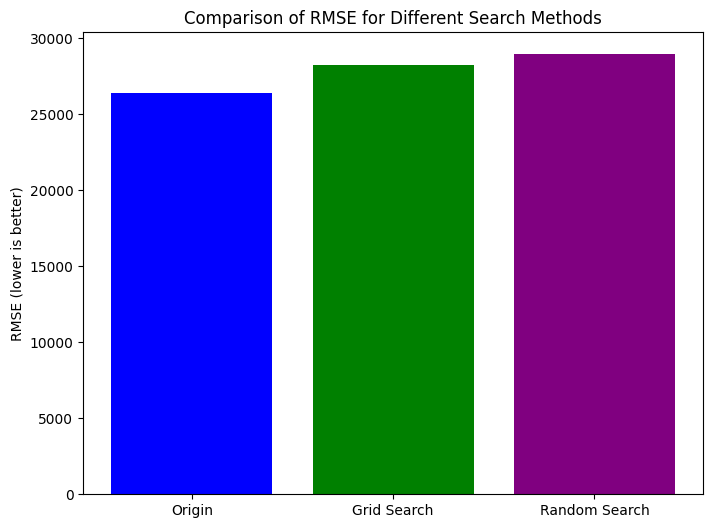

In [ ]:
methods = ['Origin', 'Grid Search', 'Random Search']
rmse_values = [origin_rmse, grid_rmse, random_rmse]

plt.figure(figsize=(8, 6))
plt.bar(methods, rmse_values, color=['blue', 'green', 'purple'])
plt.title('Comparison of RMSE for Different Search Methods')
plt.ylabel('RMSE (lower is better)')
plt.show()

# Trực quan hoá đánh giá của các mô hình trên tập Test

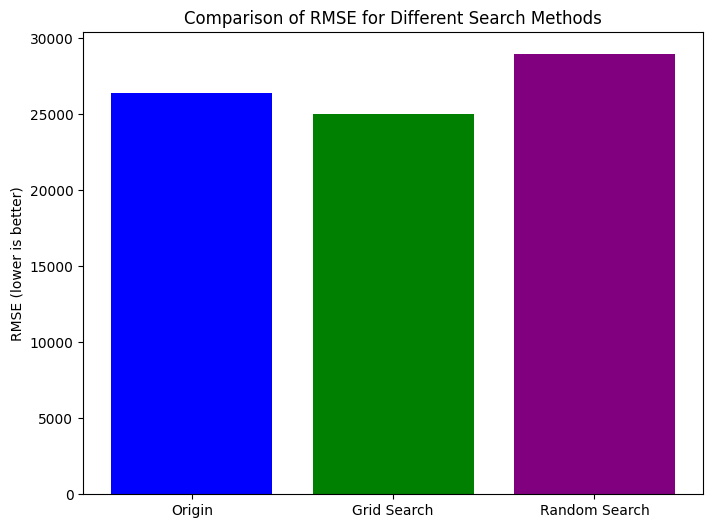

In [ ]:
import matplotlib.pyplot as plt

# Dự đoán trên tập test với 3 mô hình
ori_y_pred = origin_model.predict(dtest)
grid_y_pred = grid_search.best_estimator_.predict(X_test)
random_y_pred = random_search.best_estimator_.predict(X_test)

# Đánh giá trên tập test
origin_rmse = mean_squared_error(y_test, ori_y_pred, squared=False)
grid_rmse = mean_squared_error(y_test, grid_y_pred, squared=False)
random_y_pred = random_search.best_estimator_.predict(X_test)

methods = ['Origin', 'Grid Search', 'Random Search']
rmse_values = [origin_rmse, grid_rmse, random_rmse]

plt.figure(figsize=(8, 6))
plt.bar(methods, rmse_values, color=['blue', 'green', 'purple'])
plt.title('Comparison of RMSE for Different Search Methods')
plt.ylabel('RMSE (lower is better)')
plt.show()

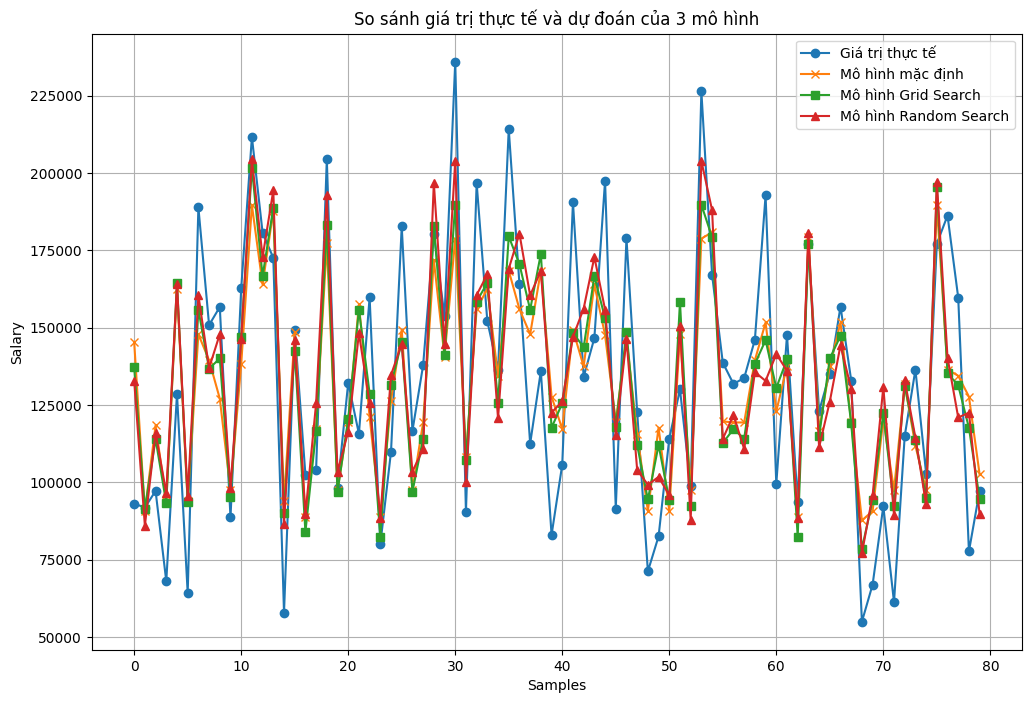

In [ ]:
# Biểu đồ đường: So sánh giá trị thực tế với 3 mô hình
plt.figure(figsize=(12, 8))
plt.plot(y_test.values, label='Giá trị thực tế', marker='o')
plt.plot(ori_y_pred, label='Mô hình mặc định', marker='x')
plt.plot(grid_y_pred, label='Mô hình Grid Search', marker='s')
plt.plot(random_y_pred, label='Mô hình Random Search', marker='^')
plt.title('So sánh giá trị thực tế và dự đoán của 3 mô hình')
plt.xlabel('Samples')
plt.ylabel('Salary')
plt.legend()
plt.grid(True)
plt.show()

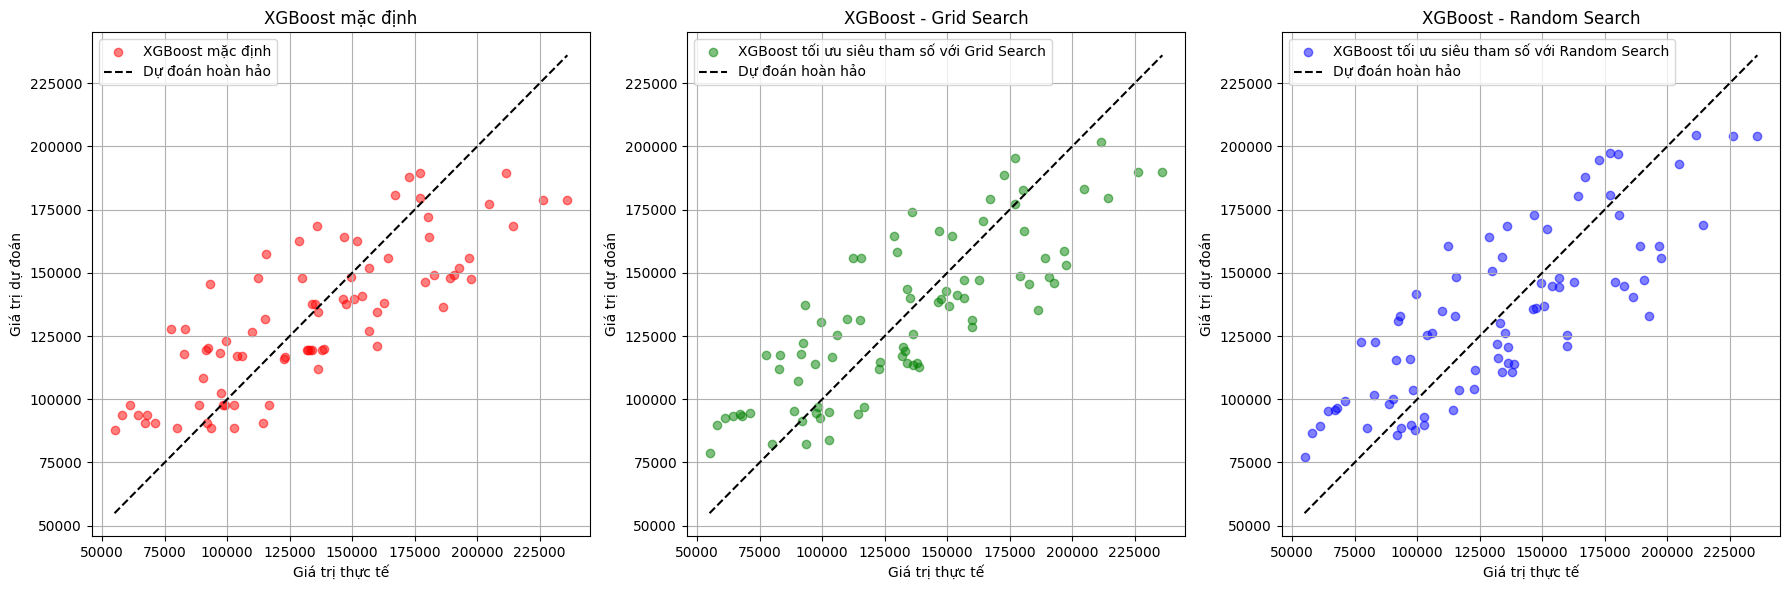

In [ ]:
# Tạo 3 subplots cho 3 mô hình (1 hàng, 3 cột)
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Danh sách dự đoán, nhãn, và tiêu đề cho các mô hình
pred_list = [ori_y_pred, grid_y_pred, random_y_pred]
label_list = ['XGBoost mặc định', 'XGBoost tối ưu siêu tham số với Grid Search', 'XGBoost tối ưu siêu tham số với Random Search']
title_list = ['XGBoost mặc định', 'XGBoost - Grid Search', 'XGBoost - Random Search']
color_list = ['red', 'green', 'blue']

# Biểu đồ phân tán cho từng mô hình trong từng subplot
for i, (pred, label, title, color) in enumerate(zip(pred_list, label_list, title_list, color_list)):
    axs[i].scatter(y_test, pred, color=color, alpha=0.5, label=label)
    axs[i].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label='Dự đoán hoàn hảo')
    axs[i].set_title(title)
    axs[i].set_xlabel('Giá trị thực tế')
    axs[i].set_ylabel('Giá trị dự đoán')
    axs[i].legend()
    axs[i].grid(True)

# Hiển thị các biểu đồ
plt.tight_layout()
plt.show()